In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Users\\Muhammad Raihan\\Downloads\\Obfuscated-MalMem2022.csv") #DM--> Dataset Malware

In [3]:
#Feature Selection
X = DM.drop(['Category','Class'],axis=1).values    #Droping this because classification model will not accept object type elements (float and int only)
# Target variable
y = DM['Class'].values

In [4]:
#Data Fitting and choosing the important variables
extratrees = ek.ExtraTreesClassifier().fit(X,y)
model = SelectFromModel(extratrees, prefit=True)
X_new = model.transform(X)
nbfeatures = X_new.shape[1]

In [5]:
features = []
index = numpy.argsort(extratrees.feature_importances_)[::-1][:nbfeatures]

In [6]:
#All the required features
for f in range(nbfeatures):
    print("%d. feature %s (%f)" % (f + 1, DM.columns[2+index[f]], extratrees.feature_importances_[index[f]]))
    features.append(DM.columns[2+f])

1. feature handles.nhandles (0.117705)
2. feature ldrmodules.not_in_load (0.100351)
3. feature handles.ndesktop (0.082414)
4. feature dlllist.avg_dlls_per_proc (0.070902)
5. feature ldrmodules.not_in_load_avg (0.057402)
6. feature svcscan.interactive_process_services (0.044922)
7. feature svcscan.shared_process_services (0.044113)
8. feature ldrmodules.not_in_mem (0.041379)
9. feature handles.nthread (0.040579)
10. feature pslist.nprocs64bit (0.032297)
11. feature handles.avg_handles_per_proc (0.029544)
12. feature svcscan.fs_drivers (0.028447)
13. feature ldrmodules.not_in_init (0.028357)
14. feature pslist.avg_threads (0.027926)
15. feature handles.nsection (0.026944)
16. feature svcscan.kernel_drivers (0.026541)
17. feature callbacks.nanonymous (0.025724)
18. feature handles.ntimer (0.022361)
19. feature handles.ndirectory (0.022222)
20. feature handles.nmutant (0.020472)


In [7]:
# Memilih 10% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('Class').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)

In [8]:
# Mencoba mencari threshold terbaik pada fitur yang dipilih
hasil_threshold = []

def Thresholding(threshold, feature):
    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # menentukan TP, TN, FP, FN
    from sklearn.metrics import confusion_matrix

    # Untuk BenignDataThreshold
    y_true_benign = ["Benign"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["Class"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["Malware"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["Class"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp/(tp+fp) if (tp+fp) != 0 else 0
    RecallThreshold = tp/(tp+fn) if (tp+fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold*RecallThreshold)/(PrecisionThreshold+RecallThreshold)) if (PrecisionThreshold+RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp+tn)/(tp+fp+tn+fn) if (tp+fp+tn+fn) != 0 else 0

    matrix = [[feature, threshold], [PrecisionThreshold], [RecallThreshold], [F1ScoreThreshold], [AccuracyThreshold]]
    hasil_threshold.append(matrix)

for feature in tqdm(features, desc='Progress'):
    Max = sampled_data[feature].max()
    Min = sampled_data[feature].min()

    for x in range(int(Min), int(Max + 1)):
        Thresholding(x, feature)

print(hasil_threshold)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [20:56<00:00, 62.80s/it]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [9]:
winner = [['', 0], [0], [0], [0], [0]]  # Format: [[feature, threshold], [precision], [recall], [f1-score], [accuracy]]

for result in hasil_threshold:
    if result[4][0] > winner[4][0]:
        winner = result

print(f"Dengan fitur {winner[0][0]} dan threshold {winner[0][1]}, menghasilkan akurasi {winner[4][0]} yang menjadikan angka threshold tersebut adalah threshold terbaik yang dapat digunakan.")


Dengan fitur handles.nmutant dan threshold 294, menghasilkan akurasi 0.9887372013651877 yang menjadikan angka threshold tersebut adalah threshold terbaik yang dapat digunakan.


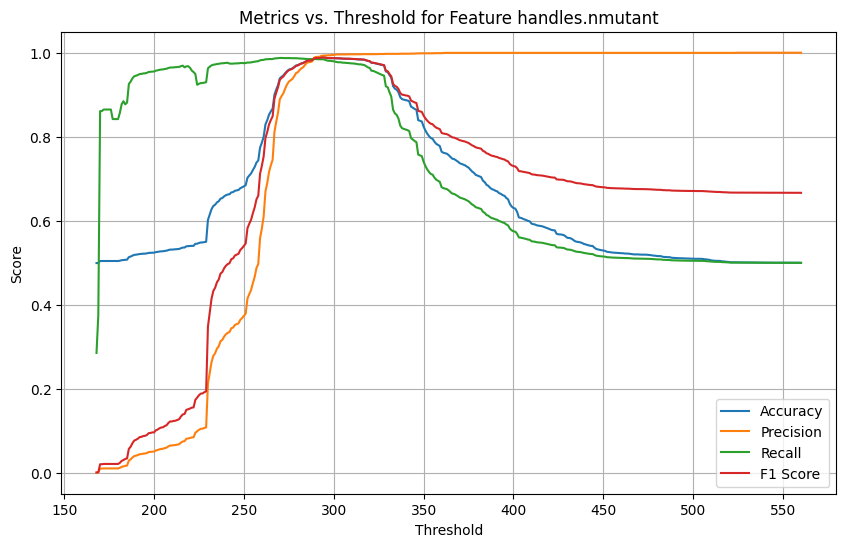

In [10]:
# Mendapatkan fitur pemenang dan thresholdnya
winner_feature, winner_threshold = winner[0]

# Memfilter hasil threshold untuk fitur pemenang
winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

# Pisahkan hasil menjadi list berdasarkan feature dan kolom
thresholds, precision, recall, f1_score, accuracy = [], [], [], [], []
for result in winner_results:
    thresholds.append(result[0][1])
    precision.append(result[1][0])
    recall.append(result[2][0])
    f1_score.append(result[3][0])
    accuracy.append(result[4][0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy, label='Accuracy')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1_score, label='F1 Score')

plt.title(f'Metrics vs. Threshold for Feature {winner_feature}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
